<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
'SiPM DST' Study</p><br>

# Ilustrates the data structure to prepare a DST from FLEX data

In [2]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [10]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# Specific IC stuff
import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


In [16]:
from nextflex.krypton_dst import get_evt_true_positions_and_energy
from nextflex.krypton_dst import NN

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

# Code

# DATA

In [20]:
VERBOSITY = False

# Input data

In [92]:
iPATH = "/Users/jj/Development/demoData/flex3+2"

In [93]:
ifnames = glob.glob(f"{iPATH}/*.h5")

if VERBOSITY:
    print(f"{len(ifnames)} input file names ...\n")
    for ifname in ifnames:
        print(ifname)
        #print(get_event_numbers_in_file(ifname))
else:
    print(f"{len(ifnames)} input file names ...\n")

250 input file names ...



In [94]:
# Verbosing main config parameters
mcConfig = load_mcconfiguration(ifnames[0])
mcConfig.set_index("param_key", inplace = True)
main_params = ["/Geometry/NextFlex/e_lifetime", "/Geometry/NextFlex/el_gap_length",
               "/Geometry/NextFlex/el_field_int", "/Geometry/NextFlex/tp_sipm_anode_dist",
               "/Geometry/NextFlex/tp_teflon_thickness", "/Geometry/NextFlex/tp_teflon_hole_diam",
               "/Geometry/NextFlex/tp_sipm_sizeX", "/Geometry/NextFlex/tp_sipm_pitchX",
               "num_events", "TP_SiPM_binning", "F_SENSOR_L_binning", "F_SENSOR_R_binning"]
print(mcConfig.loc[main_params])


                                                param_value
param_key                                                  
/Geometry/NextFlex/e_lifetime                     10000. ms
/Geometry/NextFlex/el_gap_length                    10.  mm
/Geometry/NextFlex/el_field_int             16. kilovolt/cm
/Geometry/NextFlex/tp_sipm_anode_dist              13.1  mm
/Geometry/NextFlex/tp_teflon_thickness               8.  mm
/Geometry/NextFlex/tp_teflon_hole_diam               3.  mm
/Geometry/NextFlex/tp_sipm_sizeX                    1.0  mm
/Geometry/NextFlex/tp_sipm_pitchX                  15.55 mm
num_events                                              200
TP_SiPM_binning                                1.000000 mus
F_SENSOR_L_binning                             1.000000 mus
F_SENSOR_R_binning                             1.000000 mus


In [95]:
par = mcConfig.loc["/Geometry/NextFlex/tp_sipm_pitchX"]
par

param_value           15.55 mm
Name: /Geometry/NextFlex/tp_sipm_pitchX, dtype: object

## Extract pitch from params

In [96]:
pitch = float(par.param_value.split(' ')[-2])
pitch

15.55

## SiPMs are at indices < 10000 in dataframes 

In [97]:
sipm_index = 100000

## read SiPM map

In [98]:
sipm_map = pd.read_csv('sipm_map.csv')

In [99]:
sipm_map

,Unnamed: 0,sensor_id,sensor_name,x,y,xl,xr,yu,yd,id_xl,id_xr,id_yu,id_yd
0,0,1040,TP_SiPM,15.55,-450.95,1.907349e-07,31.100000,-435.400012,-466.500012,1039,1041,1066,1019
1,1,4059,TP_SiPM,93.30,450.95,7.775000e+01,108.850003,466.500012,435.400012,4058,4060,4080,4033
2,2,3753,TP_SiPM,-62.20,326.55,-7.775000e+01,-46.650001,342.099988,310.999988,3752,3754,3799,3705
3,3,3842,TP_SiPM,-77.75,357.65,-9.330000e+01,-62.200000,373.199994,342.099994,3841,3843,3884,3798
4,4,3797,TP_SiPM,-93.30,342.10,-1.088500e+02,-77.750003,357.650006,326.550006,3796,3798,3841,3751
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088,3088,1717,TP_SiPM,311.00,-217.70,2.954500e+02,326.550000,-202.149997,-233.249997,1716,1718,1774,1661
3089,3089,2317,TP_SiPM,357.65,-62.20,3.421000e+02,373.199994,-46.650001,-77.750001,2316,2318,2380,2255
3090,3090,1676,TP_SiPM,-326.55,-217.70,-3.421000e+02,-310.999988,-202.149997,-233.249997,1675,1677,1733,1620
3091,3091,3517,TP_SiPM,186.60,248.80,1.710500e+02,202.150006,264.350003,233.250003,3516,3518,3570,3463


## Sensors

In [100]:
get_sensor_binning(ifnames[0])

,bin_width
sns_name,
F_SENSOR_L,1000.0
F_SENSOR_R,1000.0
TP_SiPM,1000.0


In [101]:
sns_types = get_sensor_types(ifnames[0])
sns_types.head()

,sensor_id,sensor_name
0,100674,F_SENSOR_L
1,101372,F_SENSOR_L
2,100849,F_SENSOR_L
3,101414,F_SENSOR_L
4,101237,F_SENSOR_L


In [102]:
sns_positions = load_mcsensor_positions(ifnames[0])
sns_positions.head()

,sensor_id,sensor_name,x,y,z
0,100674,F_SENSOR_L,192.245895,-453.971924,-30.299999
1,101372,F_SENSOR_L,-318.937439,375.936035,-30.299999
2,100849,F_SENSOR_L,-150.914566,-469.333344,-30.299999
3,101414,F_SENSOR_L,-250.396332,424.677155,-30.299999
4,101237,F_SENSOR_L,-468.247437,154.250916,-30.299999


## True position from MC particles

#### MC Particles

In [103]:
mcParts = load_mcparticles_df(ifnames[0])
print(mcParts.columns)
mcParts

Index(['particle_name', 'primary', 'mother_id', 'initial_x', 'initial_y',
       'initial_z', 'initial_t', 'final_x', 'final_y', 'final_z', 'final_t',
       'initial_volume', 'final_volume', 'initial_momentum_x',
       'initial_momentum_y', 'initial_momentum_z', 'final_momentum_x',
       'final_momentum_y', 'final_momentum_z', 'kin_energy', 'length',
       'creator_proc', 'final_proc'],
      dtype='object')


particle_name  primary  mother_id   initial_x  \
event_id particle_id                                                 
43800    2                      e-     True          0  100.423462   
         1                      e-     True          0  100.423462   
43801    2                      e-     True          0 -200.833054   
         1                      e-     True          0 -200.833054   
43802    2                      e-     True          0 -203.925842   
...                            ...      ...        ...         ...   
43998    402957                 e-    False          2  237.655899   
         402956                 e-    False          2  237.655899   
         1                      e-     True          0  237.707016   
43999    2                      e-     True          0 -137.847778   
         1                      e-     True          0 -137.847778   

                       initial_y    initial_z  initial_t     final_x  \
event_id particle_id                                                   
43800    2           -359.637268   600.319031   0.000000  100.437309   
         1           -359.637268   600.319031   0.000000  100.445885   
43801    2           -368.407928  1013.702393   0.000000 -200.834351   
         1           -368.407928  1013.702393   0.000000 -200.890045   
43802    2           -351.085602   371.286224   0.000000 -203.907822   
...                          ...          ...        ...         ...   
43998    402957       331.363312   464.323669   0.000328  237.655792   
         402956       331.363312   464.323669   0.000328  237.654327   
         1            331.288605   464.362274   0.000000  237.742920   
43999    2           -156.988174   366.790466   0.000000 -137.855316   
         1           -156.988174   366.790466   0.000000 -137.781052   

                         final_y      final_z  ...  initial_momentum_x  \
event_id particle_id                           ...                       
43800    2           -359.653992   600.306091  ...            0.058573   
         1           -359.517120   600.266052  ...           -0.081750   
43801    2           -368.400055  1013.690491  ...           -0.004135   
         1           -368.513489  1013.836975  ...           -0.044218   
43802    2           -351.080719   371.285370  ...            0.095951   
...                          ...          ...  ...                 ...   
43998    402957       331.363190   464.323608  ...            0.008408   
         402956       331.353210   464.316498  ...           -0.064196   
         1            331.247345   464.371155  ...            0.079713   
43999    2           -156.996857   366.808472  ...            0.054028   
         1           -156.997849   366.740723  ...           -0.018118   

                     initial_momentum_y initial_momentum_z  final_momentum_x  \
event_id particle_id                                                           
43800    2                    -0.077703           0.014914               0.0   
         1                     0.068717           0.149943               0.0   
43801    2                    -0.081441           0.055148               0.0   
         1                    -0.098263           0.149255              -0.0   
43802    2                    -0.003990          -0.021644               0.0   
...                                 ...                ...               ...   
43998    402957                0.012132          -0.005727              -0.0   
         402956               -0.049221          -0.025433               0.0   
         1                    -0.073692           0.093710               0.0   
43999    2                    -0.055916          -0.060377              -0.0   
         1                    -0.183193           0.000206               0.0   

                      final_momentum_y  final_momentum_z  kin_energy  \
event_id particle_id                                                   
43800    2               

In [104]:
mcParts.index

MultiIndex([(43800,      2),
            (43800,      1),
            (43801,      2),
            (43801,      1),
            (43802,      2),
            (43802,      1),
            (43803,      3),
            (43803,      2),
            (43803, 381166),
            (43803, 381165),
            ...
            (43998, 402962),
            (43998, 402961),
            (43998, 402960),
            (43998, 402959),
            (43998, 402958),
            (43998, 402957),
            (43998, 402956),
            (43998,      1),
            (43999,      2),
            (43999,      1)],
           names=['event_id', 'particle_id'], length=1050)

In [105]:
evt_truePos = mcParts.loc[pd.IndexSlice[:, 1], ['initial_x', 'initial_y', 'initial_z']]

In [106]:
evt_truePos

,,initial_x,initial_y,initial_z
event_id,particle_id,,,
43800,1,100.423462,-359.637268,600.319031
43801,1,-200.833054,-368.407928,1013.702393
43802,1,-203.925842,-351.085602,371.286224
43803,1,66.375092,211.328018,790.279419
43804,1,14.752851,318.903137,361.975098
...,...,...,...,...
43995,1,-363.491058,-55.663517,629.826294
43996,1,183.927017,118.568687,1109.172607
43997,1,211.125763,409.218475,375.307983


In [107]:
mcParts.index[0][0]

43800

In [108]:
evt0 = mcParts[mcParts.primary].loc[mcParts.index[0][0]]

In [109]:
evt0

,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
particle_id,,,,,,,,,,,,,,,,,,,,,
2,e-,True,0,100.423462,-359.637268,600.319031,0.0,100.437309,-359.653992,600.306091,...,0.058573,-0.077703,0.014914,0.0,-0.0,-0.0,0.009396,0.069855,none,Scintillation
1,e-,True,0,100.423462,-359.637268,600.319031,0.0,100.445885,-359.517120,600.266052,...,-0.081750,0.068717,0.149943,0.0,0.0,0.0,0.032147,0.531874,none,Scintillation


## Krypton energy in keV

In [110]:
Ekr = np.sum(evt0.kin_energy)*1e+3
print(f'Krypton energy in keV = {Ekr}')

Krypton energy in keV = 41.543297469615936


In [111]:
grouped_multiple = mcParts.groupby(['event_id']).agg({'kin_energy': ['sum']})
grouped_multiple.columns = ['KE']
KEdf = grouped_multiple.reset_index()
KEdf

,event_id,KE
0,43800,0.041543
1,43801,0.041543
2,43802,0.041543
3,43803,0.053814
4,43804,0.041543
...,...,...
195,43995,0.041543
196,43996,0.041543
197,43997,0.041543
198,43998,0.053549


## S1 time

In [112]:
s1_time = 1 * units.mus

#### MC Hits

In [113]:
mcHits = load_mchits_df(ifnames[0])
print(mcHits.columns)
mcHits.head()

Index(['x', 'y', 'z', 'time', 'energy', 'label'], dtype='object')


x           y           z      time  \
event_id particle_id hit_id                                                 
43800    2           0       100.425667 -359.640778  600.320312  0.000077   
                     1       100.428307 -359.640625  600.322510  0.000137   
                     2       100.430824 -359.638214  600.324341  0.000208   
                     3       100.434769 -359.639282  600.325500  0.000284   
                     4       100.437798 -359.638184  600.323669  0.000350   

                               energy   label  
event_id particle_id hit_id                    
43800    2           0       0.000085  ACTIVE  
                     1       0.000153  ACTIVE  
                     2       0.000075  ACTIVE  
                     3       0.000067  ACTIVE  
                     4       0.000102  ACTIVE

In [114]:
true_positions = get_evt_true_positions_and_energy(mcParts)

In [115]:
true_positions

,true_x,true_y,true_z,KE
event_id,,,,
43800,100.423462,-359.637268,600.319031,41.543297
43801,-200.833054,-368.407928,1013.702393,41.543297
43802,-203.925842,-351.085602,371.286224,41.543297
43803,66.375092,211.328018,790.279419,53.813950
43804,14.752851,318.903137,361.975098,41.543297
...,...,...,...,...
43995,-363.491058,-55.663517,629.826294,41.543297
43996,183.927017,118.568687,1109.172607,41.543297
43997,211.125763,409.218475,375.307983,41.543297


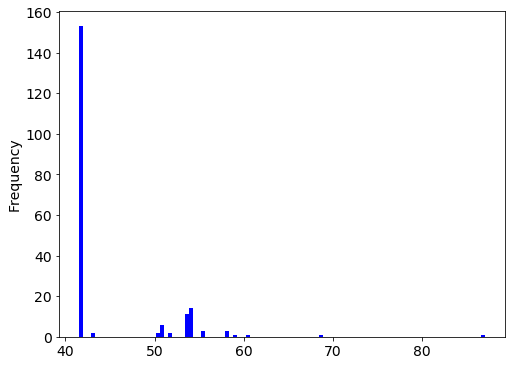

In [116]:
true_positions['KE'].plot(kind='hist', bins=100, color='blue')

In [117]:
def histo_var(df, var, varmin, varmax, bins=10, alpha=0.6, color='g'):
    df1 = df[df[var] < varmax]
    df2 = df1[df1[var] > varmin]
    plt.hist(df2[var].values, bins=bins, alpha=alpha, color=color)
    
    

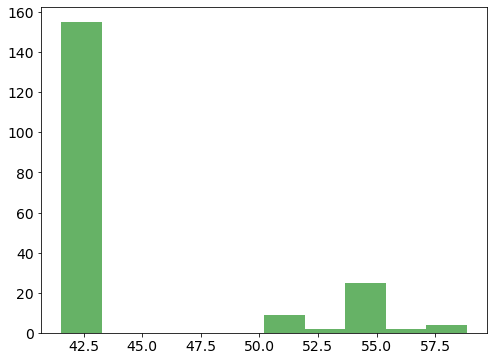

In [118]:
histo_var(true_positions, var='KE', varmin=40, varmax=60, bins=10, alpha=0.6, color='g')

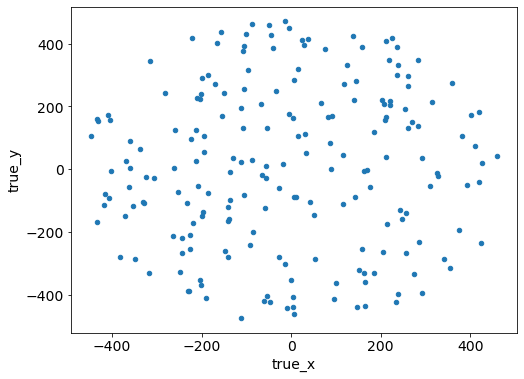

In [119]:
true_positions.plot(kind='scatter', x='true_x', y='true_y')

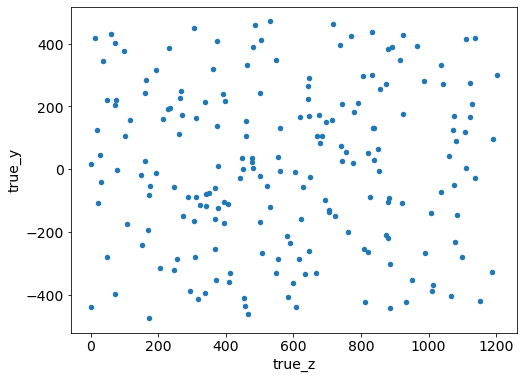

In [120]:
true_positions.plot(kind='scatter', x='true_z', y='true_y')

## SENSORS RESPONSE

In [121]:
sns_response = load_mcsensor_response_df(ifnames[0])
sns_response

charge      time
event_id sensor_id                  
43800    100674          1  597000.0
         100674          1  598000.0
         100674          2  599000.0
         100674          9  600000.0
         100674          9  601000.0
...                    ...       ...
43915    1936            1  881000.0
43917    1936            1  456000.0
43921    1936            1  621000.0
43949    1936            1    4000.0
43989    1936            1  407000.0

[4107317 rows x 2 columns]

In [122]:
sipm_response = sns_response[sns_response.index \
                               .get_level_values("sensor_id") < sipm_index]

In [123]:
sipm_response

charge       time
event_id sensor_id                   
43800    1406            1   600000.0
43811    1406            1  1138000.0
43851    1406            1   891000.0
43858    1406            3   204000.0
         1406            7   205000.0
...                    ...        ...
43915    1936            1   881000.0
43917    1936            1   456000.0
43921    1936            1   621000.0
43949    1936            1     4000.0
43989    1936            1   407000.0

[61664 rows x 2 columns]

In [124]:
fibers_response = sns_response[sns_response.index.get_level_values("sensor_id") >= sipm_index]

In [125]:
fibers_response

charge      time
event_id sensor_id                  
43800    100674          1  597000.0
         100674          1  598000.0
         100674          2  599000.0
         100674          9  600000.0
         100674          9  601000.0
...                    ...       ...
43998    201068          1  469000.0
43999    201068          3  368000.0
         201068          3  369000.0
         201068          3  370000.0
         201068          3  371000.0

[4045653 rows x 2 columns]

In [126]:
grouped_multiple = sipm_response.groupby(['event_id', 'sensor_id']).agg({'charge': ['sum']})
grouped_multiple.columns = ['tot_charge']
sipmdf = grouped_multiple.reset_index()
sipmdf


,event_id,sensor_id,tot_charge
0,43800,1000,1
1,43800,1009,1
2,43800,1019,1
3,43800,1021,1
4,43800,1025,1
...,...,...,...
53558,43999,4053,1
53559,43999,4059,1
53560,43999,4062,1
53561,43999,4065,1


In [129]:
sipm0 = sipmdf[sipmdf.event_id==43800]
sipm0

,event_id,sensor_id,tot_charge
0,43800,1000,1
1,43800,1009,1
2,43800,1019,1
3,43800,1021,1
4,43800,1025,1
...,...,...,...
271,43800,4047,1
272,43800,4061,1
273,43800,4072,1
274,43800,4084,1


In [130]:
sipm0.tot_charge.max()

29

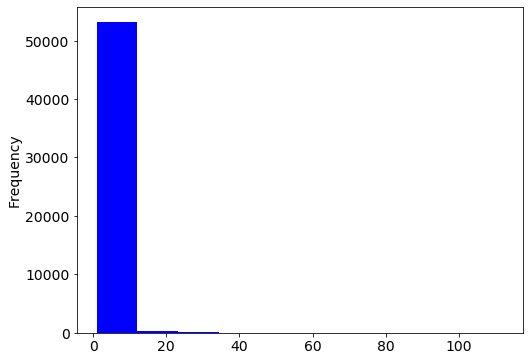

In [131]:
sipmdf['tot_charge'].plot(kind='hist', color='blue')

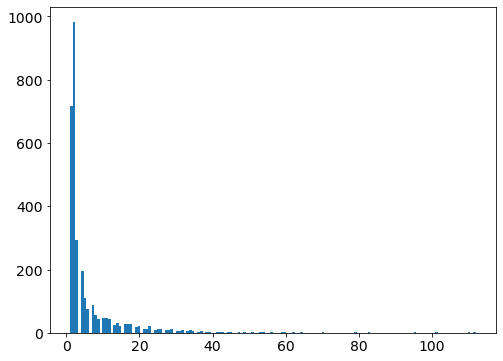

In [132]:
_, _, _ = plt.hist(sipmdf.groupby('sensor_id').tot_charge.max(), bins=150)

In [133]:
true_positions['S1e'] = fibers_response[fibers_response.time < s1_time].groupby('event_id').charge.sum()
true_positions['S2e'] = fibers_response[fibers_response.time > s1_time].groupby('event_id').charge.sum()

In [134]:
true_positions

,true_x,true_y,true_z,KE,S1e,S2e
event_id,,,,,,
43800,100.423462,-359.637268,600.319031,41.543297,110,53649
43801,-200.833054,-368.407928,1013.702393,41.543297,117,55181
43802,-203.925842,-351.085602,371.286224,41.543297,95,55155
43803,66.375092,211.328018,790.279419,53.813950,90,52962
43804,14.752851,318.903137,361.975098,41.543297,91,51949
...,...,...,...,...,...,...
43995,-363.491058,-55.663517,629.826294,41.543297,117,54060
43996,183.927017,118.568687,1109.172607,41.543297,106,51879
43997,211.125763,409.218475,375.307983,41.543297,102,59720


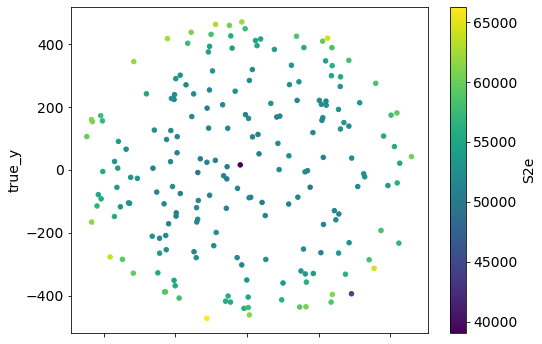

In [135]:
true_positions.plot(kind='scatter', x='true_x', y='true_y', c='S2e', cmap='viridis')

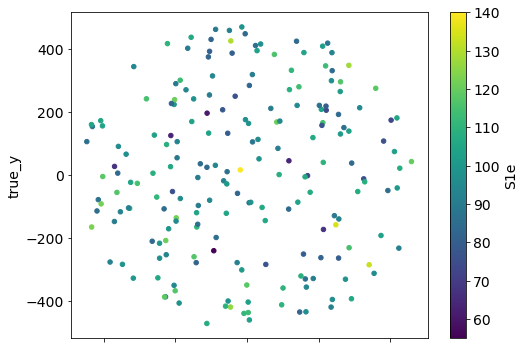

In [136]:
true_positions.plot(kind='scatter', x='true_x', y='true_y', c='S1e', cmap='viridis')